## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
import skimage
from skimage import transform

In [3]:
import hw

## Load data

In [4]:
cropped_data_dir = 'data/CroppedYale/'
cropped = hw.LoadCropped(cropped_data_dir)

In [5]:
X             = cropped.X
y             = cropped.y
h             = cropped.h
w             = cropped.w
target_names  = cropped.target_names
n_samples     = cropped.n_samples
n_features    = cropped.n_features
n_classes     = cropped.n_classes

## Downsample images

In [6]:
ims = []
for i in cropped.X:
    ims.append(i.reshape(h,w))
images = np.array(ims)

ims = []
for i in images:
    im = skimage.transform.rescale(i, 0.2)
    ims.append(im)
ims = np.array(ims)

h = ims.shape[1]
w = ims.shape[2]

X = []
for i in ims:
    X.append(i.flatten())
X = np.array(X)

## Split into training and test data


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

## K-means classification with cross-validation

In [8]:
classes = 8

In [9]:
param_grid = {'tol': [0.001,0.1,1,10]}
model = cluster.KMeans(n_clusters=classes,
                       random_state=42, 
                       n_jobs=-1)

In [39]:
%%time
clf = GridSearchCV(model, param_grid)
clf = clf.fit(X_train)

CPU times: user 2.81 s, sys: 1.55 s, total: 4.35 s
Wall time: 34.3 s


In [11]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.001, verbose=0)


In [38]:
clf.cv_results_

{'mean_fit_time': array([1.9420023 , 1.68595123, 1.43877506, 1.3256897 ]),
 'std_fit_time': array([0.56311687, 0.0971206 , 0.04407254, 0.04005456]),
 'mean_score_time': array([0.00377531, 0.0035996 , 0.00339894, 0.00343704]),
 'std_score_time': array([3.57496091e-04, 1.47641167e-04, 6.67071836e-05, 5.78757356e-05]),
 'param_tol': masked_array(data=[0.001, 0.1, 1, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'tol': 0.001}, {'tol': 0.1}, {'tol': 1}, {'tol': 10}],
 'split0_test_score': array([-8774.13142904, -8779.41832591, -8812.54441837, -8918.28685092]),
 'split1_test_score': array([-8188.61367159, -8222.26676507, -8216.01231962, -8149.70887632]),
 'split2_test_score': array([-8833.51969907, -8833.87493597, -8812.12705909, -8805.15982492]),
 'split3_test_score': array([-8653.39326449, -8653.39326449, -8664.80926133, -8701.03546679]),
 'split4_test_score': array([-9079.02688808, -9079.02688808, -9086.5258265 , -91

In [37]:
df = pd.DataFrame(clf.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                 1.942
std_fit_time               0.563117
mean_score_time          0.00377531
std_score_time          0.000357496
param_tol                     0.001
params               {'tol': 0.001}
split0_test_score          -8774.13
split1_test_score          -8188.61
split2_test_score          -8833.52
split3_test_score          -8653.39
split4_test_score          -9079.03
mean_test_score            -8705.74
std_test_score              293.431
rank_test_score                   1
Name: 0, dtype: object

In [50]:
model_labels = clf.best_estimator_.fit_predict(X_train)

In [59]:
class_count = []
average_class_images = []

for i in range(classes):
    im = X_train[(model_labels == i)]
    class_count.append(len(im))
    im = np.mean(im,axis=0)
    average_class_images.append(im)

average_class_images = np.vstack(average_class_images)

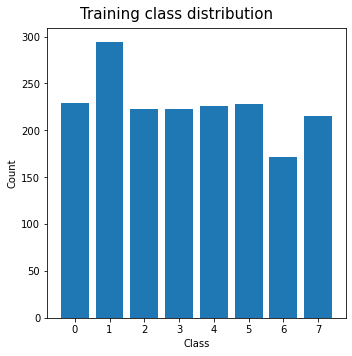

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(np.arange(classes), class_count)
ax.tick_params(axis='x')
ax.xaxis.set_ticks(np.arange(classes))

ax.set_xlabel('Class')
ax.set_ylabel('Count')
fig.suptitle('Training class distribution', fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('plots/unsupervised/km_bar_training.png');

In [61]:
labels = []
for i in np.arange(classes):
    i = 'Class: '+ str(i) + ' \n n: ' + str(class_count[i])
    labels.append(i)

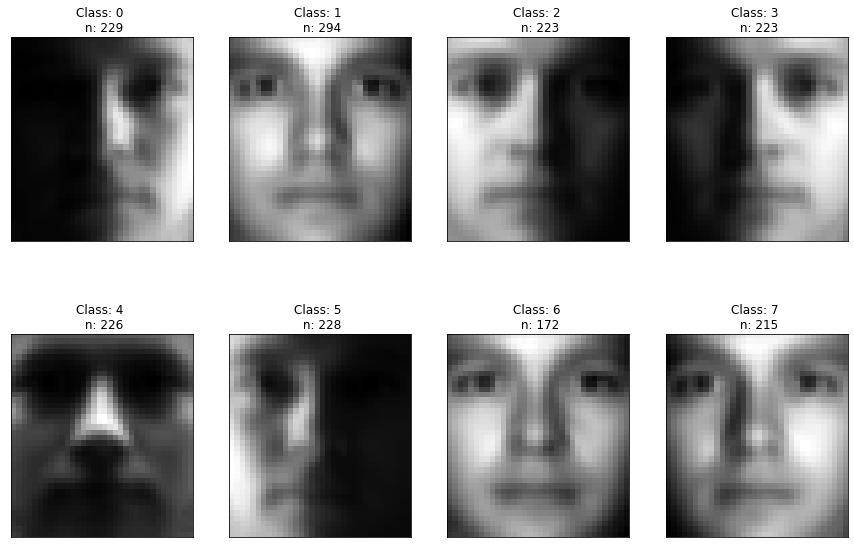

In [62]:
hw.plot_images_subset(average_class_images,
                       rows = 2,
                       columns = 4,
                       figsize= (15,10),reshape=(h,w),
                       labels = labels)
plt.savefig('plots/unsupervised/kn_classes_training.png');

In [53]:
y_pred = clf.best_estimator_.predict(X_test)

In [54]:
class_count = []
average_class_images = []

for i in range(classes):
    im = X_test[(y_pred == i)]
    class_count.append(len(im))
    im = np.mean(im,axis=0)
    average_class_images.append(im)

average_class_images = np.vstack(average_class_images)

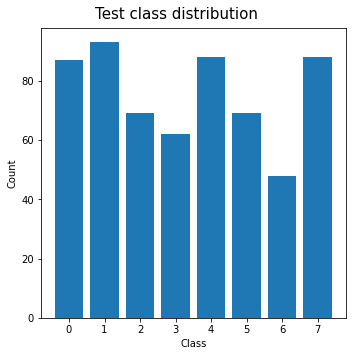

In [55]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(np.arange(classes), class_count)
ax.tick_params(axis='x')
ax.xaxis.set_ticks(np.arange(classes))

ax.set_xlabel('Class')
ax.set_ylabel('Count')
fig.suptitle('Test class distribution', fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('plots/unsupervised/km_bar_test.png');

In [56]:
labels = []
for i in np.arange(classes):
    i = 'Class: '+ str(i) + ' \n n: ' + str(class_count[i])
    labels.append(i)

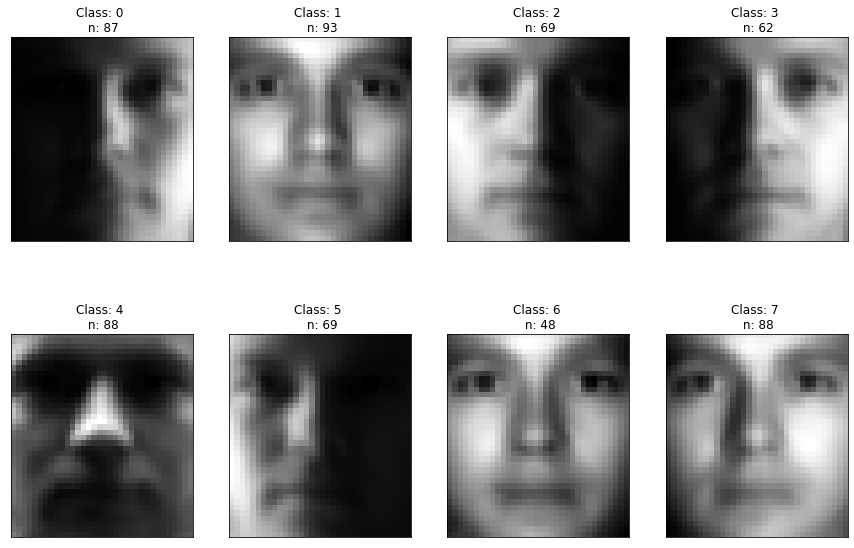

In [57]:
hw.plot_images_subset(average_class_images,
                       rows = 2,
                       columns = 4,
                       figsize= (15,10),reshape=(h,w),
                     labels = labels)
plt.savefig('plots/unsupervised/kn_classes_test.png');